In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image
%matplotlib inline
np.random.seed(2021)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 1024
transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
train_size = train_data.data.shape[0]
val_size, train_size = int(0.20 * train_size), int(0.80 * train_size) # 80 / 20 train-val split
test_size = test_data.data.shape[0]
Metric = namedtuple('Metric', ['train_loss', 'train_error', 'val_error', 'val_loss'])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=0, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(val_size, val_size+train_size))
                                         )
valloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                        num_workers=0, 
                                        sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(0, val_size))
                                         )
                                        
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=0
                                        )


In [ ]:
print(train_size)
print(val_size)
print(test_size)

48000
12000
10000


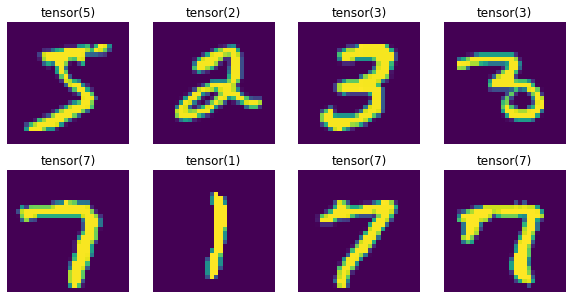

In [ ]:
idxs = [0, 5, 7, 30, 214,3412, 5555, 6666, 7777]
f, a = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    X = train_data.data[idxs[i]]
    Y = train_data.targets[idxs[i]]
    r, c = i // 4, i % 4
    a[r][c].set_title(Y)
    a[r][c].axis('off')
    a[r][c].imshow(X.numpy())
plt.draw()

In [ ]:
def one_epoch(epoch, net, loader, optimizer):
    net.train()
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0
    for i, data in enumerate(loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print statistics
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc
    
def train(net, loader, dev_loader, optimizer, epochs):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        avg_loss_t, acc_t = one_epoch(epoch, net, loader, optimizer)
        avg_loss_v, acc_v = infer(net, dev_loader)
        train_losses.append(avg_loss_t)
        valid_losses.append(avg_loss_v)
        if epoch % 5 == 0:
            print('[%d] loss: %.8f, acc: %.4f' %
                  (epoch + 1, avg_loss_t, acc_t))
            print('[valid] loss: %.8f, acc: %.4f' % (avg_loss_v, acc_v))
    return train_losses, valid_losses

def train_step(net, loader, dev_loader, optimizer, scheduler, epochs):
    net.train()
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        avg_loss_t, acc_t = one_epoch(epoch, net, loader, optimizer)
        avg_loss_v, acc_v = infer(net, dev_loader)
        scheduler.step()
        if epoch % 5 == 0:
            print('[%d] loss: %.8f, acc: %.4f' %
                  (epoch + 1, avg_loss_t, acc_t))
            print('[valid] loss: %.8f, acc: %.4f' % (avg_loss_v, acc_v))
            print("lr: {}".format(optimizer.param_groups[0]['lr']))
            
        train_losses.append(avg_loss_t)
        valid_losses.append(avg_loss_v)
    return train_losses, valid_losses
        
def infer(net, loader):
    net.eval()
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            # forward + backward + optimize
            outputs = net(inputs)
            loss = F.cross_entropy(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    avg_loss = running_loss / total
    
    return avg_loss, acc

### VISUALIZATION ###
def training_plot(a, b):
    plt.figure(1)
    plt.plot(a, 'b', label="train")
    plt.plot(b, 'g', label="valid")
    plt.title('Training/Valid Loss')
    plt.legend()
    plt.show()

[1] loss: 0.00197670, acc: 0.3059
[valid] loss: 0.00197545, acc: 0.2136
[6] loss: 0.00054946, acc: 0.8198
[valid] loss: 0.00050464, acc: 0.8347
[11] loss: 0.00045720, acc: 0.8586
[valid] loss: 0.00040604, acc: 0.8834
[16] loss: 0.00041636, acc: 0.8711
[valid] loss: 0.00037343, acc: 0.8964
[21] loss: 0.00034431, acc: 0.8943
[valid] loss: 0.00043743, acc: 0.8712
[26] loss: 0.00043497, acc: 0.8759
[valid] loss: 0.00243188, acc: 0.4585
[31] loss: 0.00028818, acc: 0.9119
[valid] loss: 0.00029051, acc: 0.9167
[36] loss: 0.00027347, acc: 0.9178
[valid] loss: 0.00029432, acc: 0.9163
[41] loss: 0.00027363, acc: 0.9162
[valid] loss: 0.00028750, acc: 0.9159
[46] loss: 0.00026313, acc: 0.9193
[valid] loss: 0.00031226, acc: 0.9088
[51] loss: 0.00024783, acc: 0.9247
[valid] loss: 0.00028764, acc: 0.9184
[56] loss: 0.00024319, acc: 0.9254
[valid] loss: 0.00044711, acc: 0.8683
[61] loss: 0.00021962, acc: 0.9333
[valid] loss: 0.00024424, acc: 0.9297
[66] loss: 0.00021302, acc: 0.9355
[valid] loss: 0.00

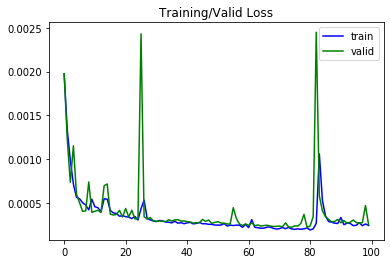

In [ ]:
### LET'S TRAIN the baseline ###
""" baseline """
model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10), 
                       )
model1 = model1.to(device)
opt1 = torch.optim.SGD(model1.parameters(), lr=0.8)
train_losses, valid_losses = train(model1, trainloader, valloader, opt1, 100)

test_loss, acc_test = infer(model1, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

[1] loss: 0.00181192, acc: 0.3546
[valid] loss: 0.00091321, acc: 0.7165
lr: 0.8
[6] loss: 0.00026620, acc: 0.9192
[valid] loss: 0.00027153, acc: 0.9207
lr: 0.8
[11] loss: 0.00023593, acc: 0.9272
[valid] loss: 0.00021175, acc: 0.9362
lr: 0.8
[16] loss: 0.00019139, acc: 0.9421
[valid] loss: 0.00019487, acc: 0.9397
lr: 0.8
[21] loss: 0.00018529, acc: 0.9436
[valid] loss: 0.00019285, acc: 0.9418
lr: 0.8
[26] loss: 0.00016167, acc: 0.9503
[valid] loss: 0.00022845, acc: 0.9343
lr: 0.8
[31] loss: 0.00017115, acc: 0.9479
[valid] loss: 0.00018276, acc: 0.9454
lr: 0.8
[36] loss: 0.00013102, acc: 0.9592
[valid] loss: 0.00017198, acc: 0.9491
lr: 0.4
[41] loss: 0.00012467, acc: 0.9619
[valid] loss: 0.00016851, acc: 0.9482
lr: 0.4
[46] loss: 0.00012026, acc: 0.9625
[valid] loss: 0.00016931, acc: 0.9487
lr: 0.4
[51] loss: 0.00011611, acc: 0.9640
[valid] loss: 0.00016458, acc: 0.9506
lr: 0.4
[56] loss: 0.00011168, acc: 0.9657
[valid] loss: 0.00016342, acc: 0.9506
lr: 0.4
[61] loss: 0.00010697, acc: 0.

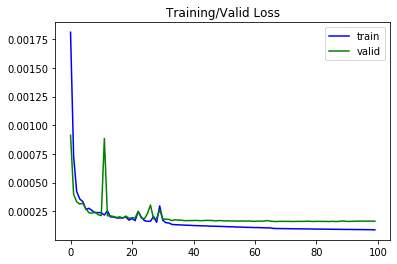

In [ ]:
### LET'S TRAIN the baseline ###
""" baseline with scheduler """
model2 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10),  
                       )
model2 = model2.to(device)
opt2 = torch.optim.SGD(model2.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(opt2, gamma=0.5, step_size=33)
train_losses, valid_losses = train_step(model2, trainloader, valloader, opt2, scheduler, 100)
test_loss, acc_test = infer(model2, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

In [ ]:
# """ dropout """
# model3 = nn.Sequential(nn.Linear(784, 20), 
#                        nn.ReLU(),
#                        nn.Linear(20, 20), 
#                        nn.ReLU(),
#                        nn.Linear(20, 10),  , 
#                        )
# model3 = model3.to(device)
# model3.apply(init_randn)
# opt3 = torch.optim.SGD(model1.parameters(), lr=0.1)
# train_losses, valid_losses = train(model3, trainloader, valloader, opt1, 150)

# test_loss, acc_test = infer(model3, testloader)
# print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
# training_plot(train_losses, valid_losses)

[1] loss: 0.00050065, acc: 0.8487
[valid] loss: 0.00028971, acc: 0.9099
[6] loss: 0.00013625, acc: 0.9583
[valid] loss: 0.00016915, acc: 0.9503
[11] loss: 0.00010391, acc: 0.9676
[valid] loss: 0.00015112, acc: 0.9567
[16] loss: 0.00008268, acc: 0.9733
[valid] loss: 0.00014073, acc: 0.9616
[21] loss: 0.00007220, acc: 0.9764
[valid] loss: 0.00015790, acc: 0.9541
[26] loss: 0.00006318, acc: 0.9786
[valid] loss: 0.00015472, acc: 0.9578
[31] loss: 0.00005793, acc: 0.9809
[valid] loss: 0.00017224, acc: 0.9549
[36] loss: 0.00004942, acc: 0.9838
[valid] loss: 0.00017817, acc: 0.9553
[41] loss: 0.00004370, acc: 0.9856
[valid] loss: 0.00019572, acc: 0.9532
[46] loss: 0.00004161, acc: 0.9859
[valid] loss: 0.00019454, acc: 0.9541
[51] loss: 0.00003661, acc: 0.9881
[valid] loss: 0.00018071, acc: 0.9577
[56] loss: 0.00003339, acc: 0.9890
[valid] loss: 0.00018644, acc: 0.9564
[61] loss: 0.00002987, acc: 0.9901
[valid] loss: 0.00020657, acc: 0.9542
[66] loss: 0.00003029, acc: 0.9893
[valid] loss: 0.00

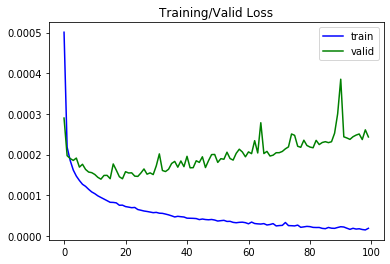

In [ ]:
""" batchnorm """
model4 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.BatchNorm1d(20),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.BatchNorm1d(20),
                       nn.Linear(20, 10),
                       )

model4 = model4.to(device)
opt4 = torch.optim.SGD(model4.parameters(), lr=0.8,weight_decay=1e-4)
loss = nn.CrossEntropyLoss()
train_losses, valid_losses = train(model4, trainloader, valloader, opt4, 100)
test_loss, acc_test = infer(model4, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

In [ ]:
"""how to know what is the best learning rate? """
""" trial and error """
### LET'S TRAIN the baseline ###
from collections import defaultdict
def find_best_lr(loader, starting_lr=1e-6, gamma=1.4, trials=5):
    lr2loss = defaultdict(list)
    for i in range(trials):
        torch.manual_seed(i)
        net = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10),  
                       )
        net = net.to(device)
        optimizer = torch.optim.SGD(model3.parameters(), lr=starting_lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
        
        last_loss = -1
        for x, y in loader:
            x = x.to(x)
            y = y.to(y)
            out = net(x)
            optimizer.zero_grad()
            loss = F.cross_entropy(out, y)
            loss.backward()
            lr = optimizer.param_groups[0]['lr']
            if last_loss != -1: lr2loss[lr].append(last_loss - loss.cpu().item())
            optimizer.step()
            scheduler.step()
            last_loss = loss.cpu().item()
    return lr2loss
            
""" baseline with scheduler """
print("# of batches: {}".format(len(trainloader)))
lr2loss = find_best_lr(trainloader, starting_lr=1e-6, gamma=1.4, trials=20)

# of batches: 47


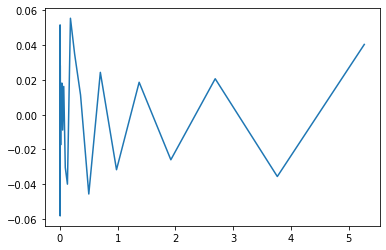

In [ ]:
lrs = list(lr2loss.keys())
vals = [sum(lr2loss[i]) for i in lrs]
plt.plot(lrs, vals)

In [ ]:
lrs[np.argmax(vals)]

0.1822255561721857

[1] loss: 0.00202340, acc: 0.3182
[valid] loss: 0.00146698, acc: 0.5357
[6] loss: 0.00035380, acc: 0.8936
[valid] loss: 0.00034427, acc: 0.9046
[11] loss: 0.00026334, acc: 0.9215
[valid] loss: 0.00026326, acc: 0.9251
[16] loss: 0.00021973, acc: 0.9344
[valid] loss: 0.00022377, acc: 0.9322
[21] loss: 0.00019180, acc: 0.9423
[valid] loss: 0.00020307, acc: 0.9404
[26] loss: 0.00016931, acc: 0.9494
[valid] loss: 0.00019470, acc: 0.9441
[31] loss: 0.00015268, acc: 0.9543
[valid] loss: 0.00018613, acc: 0.9455
[36] loss: 0.00014308, acc: 0.9567
[valid] loss: 0.00016417, acc: 0.9526
[41] loss: 0.00013047, acc: 0.9611
[valid] loss: 0.00016099, acc: 0.9526
[46] loss: 0.00012135, acc: 0.9635
[valid] loss: 0.00015168, acc: 0.9557
[51] loss: 0.00011247, acc: 0.9664
[valid] loss: 0.00015441, acc: 0.9548
[56] loss: 0.00011006, acc: 0.9668
[valid] loss: 0.00016390, acc: 0.9525
[61] loss: 0.00010108, acc: 0.9697
[valid] loss: 0.00014662, acc: 0.9581
[66] loss: 0.00009838, acc: 0.9699
[valid] loss: 0.00

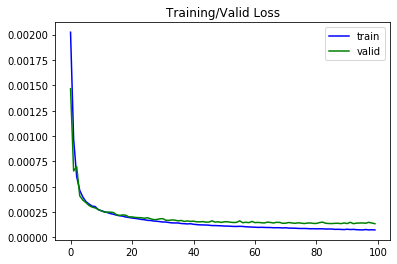

In [ ]:
### LET'S TRAIN the baseline ###
""" baseline """
model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10), 
                       )
model1 = model1.to(device)
opt1 = torch.optim.SGD(model1.parameters(), lr=0.182)
train_losses, valid_losses = train(model1, trainloader, valloader, opt1, 100)
test_loss, acc_test = infer(model1, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

In [ ]:
opt1.param_groups[0]['lr'] = 0.09
train_losses, valid_losses = train(model1, trainloader, valloader, opt1, 15)

[1] loss: 0.00006589, acc: 0.9802
[valid] loss: 0.00013608, acc: 0.9612
[6] loss: 0.00006490, acc: 0.9807
[valid] loss: 0.00013626, acc: 0.9626
[11] loss: 0.00006319, acc: 0.9809
[valid] loss: 0.00013829, acc: 0.9615


In [ ]:
test_loss, acc_test = infer(model1, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))

Final TEST SCORE: loss: 0.00013314262107014656 acc: 0.962
